In [818]:
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas as pd
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn as sns #Makes the plots look nice
import scipy #Some stats

import pickle #if you want to save layouts
import os
import operator
from googletrans import Translator

%matplotlib inline

In [1032]:
print(len(list(bookDF_male_tokenized.columns)))

136


### <span style="color:green"> General Notes: 
### <span style="color:green">  For this assignment, I combine Exercise 1, 2 and 3. (Exercise 3's stretch has its separate section)

<span style="color:green"> For me to get a meaningful network (Exercise 1's requirement), I need to use POS tags to filter out some words, which is the requirement of Exercise 3. Network statistics (Exercise 2) is mainly reflected in the matplotlib line graph where I show how the centerality of the four gender words "male_he", "male_she", "female_he", and "female_she" changes as the network gets trimmed.

In [2]:
bookDF_male_tokenized= pd.read_pickle("bookDF_male_tokenized.pickle")
bookDF_female_tokenized= pd.read_pickle("bookDF_female_tokenized.pickle")

<span style="color:green"> I first build a (long) list of vocabulary as the first screening step. I use POS tag to screen out words that have relevant tags. 
    
<span style="color:green"> I tried two sets of words, adjective and nouns. There is significantly more nouns than adjectives, so if I want to see anything adjectives related. I cannot include nouns as target words. 

In [697]:
keep_tag= ["a", "ag", "ad", "an", "i", "z"]
#"vg", "v", "vd", "vn"
#"a", "ag", "ad", "an", "i", "z"
#"n", "ns", "ng"

helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_tag"]

bookDF_tag= pd.concat([bookDF_male_tokenized[helper_col], bookDF_female_tokenized[helper_col]], axis= 0)
#bookDF_tag_male= bookDF_male_tokenized[helper_col]
#bookDF_tag_female= bookDF_female_tokenized[helper_col]


def build_vocabulary(DF, keep_tag):
    #Input 1: a dataframe that contains 30 columns (30 chapter) of books. 
    #Each column contains a list of word tag tuple
    #Input 2: words with corresponding POS tags that I want to keep 
    #Output a vocabulary list
    voc= set()
    tag_column= []
    for i in range(30):
        tag_column+= ["ch"+str(i+1)+"_tag"]
    for j in range(DF.shape[0]):
        for col in tag_column:
            word_tag_list= DF.iloc[j][col]
            for w, t in word_tag_list:
                if t in keep_tag:
                    voc.add(w)
    return voc
            
voc= build_vocabulary(bookDF_tag, keep_tag)
        

In [698]:
len(voc)

40354

<span style="color:green"> I use tf-idf to find the 1000 most distinguishing words *at the document level*. Else there are way too many stop words or words with little meaning. 

In [699]:
helper_col= []
for i in range(30):
    helper_col+= ["ch"+str(i+1)+"_clean"]
        
bookDF_ch= pd.concat([bookDF_male_tokenized[helper_col], bookDF_female_tokenized[helper_col]], axis= 0)
#bookDF_ch_male= bookDF_male_tokenized[helper_col]
#bookDF_ch_female= bookDF_female_tokenized[helper_col]


def collapse_30_ch_to_string(DF):
    #This function collapses the 30 chapters (30 columns) of a book into one cell
    #Then sum up the list of each book to a string, (words separated by space)
    helper_lis= [] 
    for i in range(DF.shape[0]):
        cell= []
        for col in helper_col:
            cell+= DF.iloc[i][col]

        helper_lis+= [cell]

    helper_str= []
    for i in range(DF.shape[0]):
        helper_str+= [" ".join(helper_lis[i])]

    all_ch_string_DF= pd.DataFrame({"all_ch_string": helper_str})
    
    return all_ch_string_DF

In [700]:
all_ch_string_DF= collapse_30_ch_to_string(bookDF_ch)

In [701]:
my_tf_vectorizer= sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3)
novel_tf_vects= my_tf_vectorizer.fit_transform(all_ch_string_DF["all_ch_string"])
novel_tf_vects.shape

(1000, 149845)

<span style="color:green"> I rank the tf-idf features, then look up each feature in the variable `voc` I built above until the target list reach 1000.  

In [702]:
#Rank the tf-idf features
terms = my_tf_vectorizer.get_feature_names()
sums = novel_tf_vects.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
ranked= ranking.sort_values('rank', ascending=False)

In [703]:
target_len= 1000
target= []

for t in ranked["term"]:
    if len(target)>= target_len:
        break
    if t in set(voc):
        target+= [t]

gender_target= ["male_he", "male_she", "female_he", "female_she"]
target+= gender_target

In [704]:
target_dic= {target[i]: i for i in range(len(target))}
target_dic_rev= {num: word for word, num in target_dic.items()}

In [1039]:
len(target)
finding_error= pd.DataFrame({"testing": target})
finding_error.to_csv("finding_error.csv")

<span style="color:green"> The above operation identifies the target words that I want to build networks with (i.e., the nodes). In the following, I will use the windows next to each target word to build network.

<span style="color:green"> The example codes teach me to build 1-mode network from 2-mode network (bipartite network). But I am not interested in linking words through documents. I am interested in linking words through the local context.

<span style="color:green"> I use windows next to these target words as the local context. Since I am interested in connection between words, I take windows by counting 10 words rightword (i.e., forward but not backward). 
    
<span style="color:pink"> Notes. The way I take windows here is different from the way I took windows in the classification task because here I am interested in undirected edge. I won't miss any connection or count repeatedly by going one way. But in the classification task, I am interested in the context that "he" and "she" are placed, I want both left and right windows of the words.

In [706]:
list_text_split= []
for i in range(all_ch_string_DF.shape[0]):
    text= all_ch_string_DF.iloc[i]["all_ch_string"]
    text_split= text.split()
    list_text_split+= [text_split]
bookDF_ch["30_ch_list"]= list_text_split

In [707]:
def replace_character_maleN(wordlist):
    new_wordlist= []
    for w in wordlist:
        if w== "他":
            new_wordlist+= ["male_he"]
        elif w== "她":
            new_wordlist+= ["male_she"]
        else:
            new_wordlist+= [w]
    return new_wordlist
        
def replace_character_femaleN(wordlist):
    new_wordlist= []
    for w in wordlist:
        if w== "他":
            new_wordlist+= ["female_he"]
        elif w== "她":
            new_wordlist+= ["female_she"]
        else:
            new_wordlist+= [w]
    return new_wordlist

bookDF_ch["30_ch_list_replace"]= pd.concat([bookDF_ch["30_ch_list"].iloc[:500].apply(lambda x: replace_character_maleN(x)),
                                        bookDF_ch["30_ch_list"].iloc[500:].apply(lambda x: replace_character_femaleN(x))],
                                        axis= 0)
                                        

In [708]:
net_np= np.zeros((len(target_dic), len(target_dic)))

for i in range(bookDF_ch.shape[0]):
    text= bookDF_ch["30_ch_list_replace"].iloc[i]
    
    for j in range(len(text)):
        if text[j] in target_dic:
            right= text[j: j+ 10]
            for wr in right[1:]:
                if wr in target_dic:
                    #I want to fill only half of the matrix
                    if target_dic[text[j]]< target_dic[wr]:
                        net_np[target_dic[text[j]], target_dic[wr]]+= 1
                        
                    elif target_dic[text[j]]== target_dic[wr]:
                        net_np[target_dic[text[j]], target_dic[wr]]+= 0
                        
                    else:
                        net_np[target_dic[wr], target_dic[text[j]]]+= 1
                            

In [709]:
node_node_w= []
for i in range(net_np.shape[0]):
    for j in range(i, net_np.shape[0]):
        if net_np[i, j]> 0:
            node_node_w+= [(target_dic_rev[i], target_dic_rev[j], net_np[i, j])]

In [710]:
g= nx.Graph()
g.add_weighted_edges_from(node_node_w)

In [711]:
print(nx.info(g))

#Average weight
print("Average weight:", np.mean([d["weight"] for n1, n2, d in g.edges(data = True)]))
print("Median weight:", np.median([d["weight"] for n1, n2, d in g.edges(data = True)]))

Name: 
Type: Graph
Number of nodes: 1004
Number of edges: 74237
Average degree: 147.8825
Average weight: 5.5398116842006
Median weight: 1.0


In [712]:
#Remove edges that occur less than average times
avg= np.mean([d["weight"] for n1, n2, d in g.edges(data = True)])
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= avg])
#Average weight
print(nx.info(g))
print("Average weight:", np.mean([d["weight"] for n1, n2, d in g.edges(data = True)]))

Name: 
Type: Graph
Number of nodes: 1004
Number of edges: 4702
Average degree:   9.3665
Average weight: 67.69396001701404


In [543]:
##Export network matrix to a csv file 
print(nx.info(g))
words= list(nx.nodes(g))
net= nx.to_numpy_matrix(g)
netDF= pd.DataFrame(net, columns= words, index= words)
netDF.to_csv("net_adj.csv")
#netDF.to_csv("net_v.csv")
#netDF.to_csv("net_n.csv")

Name: 
Type: Graph
Number of nodes: 1004
Number of edges: 4702
Average degree:   9.3665


<span style="color:green"> Trimming the network nodes is not favorable for my purpose. But I cannot plot overly large network here. So I export the data to Gephi to plot three graphs. 
    
<span style="color:green"> I take out the 4 gender nodes "male_he", "male_she", "female_he", and "female_she" from the network becuase they occur too much and they are the center that connects everything. If I inlcude these four nodes, then the network immediately split into two sub-graphs with "male_he" & "male_she" centering one subgraph and "female_he" & "female_she" centering the other subgraph. 

<span style="color:green"> **For adjective**: Adjectives clustered around the 4 gender words and form two clusters. But once I exclude the 4 gender words (as shown below), the ajectives themselves do not formulate any pattern. 

<img src="netadj.png",width=1000,height=500>

<span style="color:green"> **For verbs**: There are some clustering with regards to the verbs. For example, the right corner refers to ancient times setting, and the lower part refers to some intensive interactions. 

<img src="netv.png",width=1000,height=500>

<span style="color:green"> **For nouns**: Even without the 4 gender words, the nouns do clustered around certain topics. From this graph, I can see what the character settings are of the novels. This is the most informative graph out of the three graphs.

<img src="netn.png",width=1000,height=500>

### <span style="color:green"> Combine the adj, v, and n networks

<span style="color:green"> Below is a strange move. Not sure if I can justify it. I take the 333 most central adj, noun, and verb to formulate a 999 word network (actually 996 words becuase there are overlap between the words). The number 333 is completely arbitary.  

<span style="color:pink"> The codes I wrote above are also meh... For adj, noun and verb, I have to re-run everything three times. **That is, the variable `n`, `v`, `adj` below are the results of running the code above three times.**   
    
<span style="color:green"> For graphing the network, I again need to get rid of the 4 gender words, else the data form two clean clusters representing male and female novels. This is understandable becuase "he" and "she" occurs so many times and everything that happes are related to them. 

In [713]:
dcentralities = nx.degree_centrality(g)

In [714]:
adj= [w for w, v in sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:337]][4:]

In [694]:
v= [w for w, v in sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:337]][4:]

In [675]:
n= [w for w, v in sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:337]][4:]

In [730]:
#There is a three-word overlap between adj, n and v
#One between v and n: 
#One between adj and n:
#One between 
target_3= list(set(v+n+adj))

In [1037]:
set(n)& set(v)

{'小白'}

In [1020]:
def target_network(target):
    target_dic= {target[i]: i for i in range(len(target))}
    target_dic_rev= {num: word for word, num in target_dic.items()}
    

    net_np= np.zeros((len(target_dic), len(target_dic)))

    for i in range(bookDF_ch.shape[0]):
        text= bookDF_ch["30_ch_list_replace"].iloc[i]

        for j in range(len(text)):
            if text[j] in target_dic:
                right= text[j: j+ 10]
                for wr in right[1:]:
                    if wr in target_dic:
                        #I want to fill only half of the matrix
                        if target_dic[text[j]]< target_dic[wr]:
                            net_np[target_dic[text[j]], target_dic[wr]]+= 1

                        elif target_dic[text[j]]== target_dic[wr]:
                            net_np[target_dic[text[j]], target_dic[wr]]+= 0

                        else:
                            net_np[target_dic[wr], target_dic[text[j]]]+= 1
    
    node_node_w= []
    for i in range(net_np.shape[0]):
        for j in range(i, net_np.shape[0]):
            if net_np[i, j]> 0:
                node_node_w+= [(target_dic_rev[i], target_dic_rev[j], net_np[i, j])]
    
    g= nx.Graph()
    g.add_weighted_edges_from(node_node_w)
    return g


In [1021]:
g_3= target_network(target_3)
print(nx.info(g_3))

#Average weight
print("Average weight:", np.mean([d["weight"] for n1, n2, d in g_3.edges(data = True)]))
print("Median weight:", np.median([d["weight"] for n1, n2, d in g_3.edges(data = True)]))


Name: 
Type: Graph
Number of nodes: 996
Number of edges: 195287
Average degree: 392.1426
Average weight: 4.379369850527685
Median weight: 2.0


In [1025]:
#Remove edges that occur less than x times
avg= np.mean([d["weight"] for n1, n2, d in g_3.edges(data = True)])
#The filtering criterion 10 is arbitary... I just want to trim down the network to be not as dense
g_3.remove_edges_from([(n1, n2) for n1, n2, d in g_3.edges(data = True) if d['weight'] <= 10])
#Average weight
print(nx.info(g_3))
print("Average weight:", np.mean([d["weight"] for n1, n2, d in g_3.edges(data = True)]))

print("This trimimg restuls in", len(list(nx.isolates(g_3))), "isolated nodes")
#I don't have to get rid of these nodes. Gephi will automatically do that

Name: 
Type: Graph
Number of nodes: 996
Number of edges: 13548
Average degree:  27.2048
Average weight: 31.384558606436375
This trimimg restuls in 54 isolated nodes


In [941]:
#Translate nodes from Chinese to English
words= list(nx.nodes(g_3))
translator = Translator()

chi_eng_dic= {}

for chi_w in words:
    try:
        eng_w= translator.translate(chi_w).text
        chi_eng_dic[chi_w]= eng_w
    except:
        print("something is wrong:", chi_w)
        
#Not all translation are reliable... My solution is to output them to a csv file, 
#where I can easily make manual correction. Then I read the csv file back.



In [947]:
chi_eng_DF= pd.DataFrame({"chi": words, "eng": [chi_eng_dic[chi_w] for chi_w in words]})
chi_eng_DF.to_csv("chi_eng_DF.csv")

In [1027]:
#I manually correct the google translation... Took forever :(
chi_eng_correct= pd.read_excel("chi_eng_correct.xlsx", encoding= "latin-1")
eng_words= list(chi_eng_correct["eng"])

chi_words= list(nx.nodes(g_3))
#I then pair up the Chinese words with the English words
pair= [chi+eng for chi, eng in zip(chi_words, eng_words)]

In [1028]:
##Export network matrix to a csv file 
net= nx.to_numpy_matrix(g_3)
netDF= pd.DataFrame(net, columns= pair, index= pair)
netDF.to_csv("net_3_twoL.csv")

<span style="color:green"> I select the most central 333 adj, 333 noun, 333 verb from the adj, noun, and verb network. Trimming the network results in some nodes becoming isolated, which retains 942 nodes. 
    
<span style="color:green"> I notice that some nodes do not have substantive meaning and some others are people names that shouldn't be included in the first place (jieba tokenizer failed to recognize them as human names). I manually go through the word list in Gephi and further delete 16 words that I think does not contain generalized meaning about the documents. These 16 words include 1)具有 have, 2)分为 divid into, 3)叶家 family Ye, 4)司徒 Situ(a surname), 5)地说 say, 6)好似 as, 7)方氏 Ms.Fang, 8)林家 family Lin, 9)楚天 Chutian(a name), 10)楚风 Chufeng(a name), 11)沈家 family Shen, 12)瞧瞧 look, 13)瞧见 see, 14)答道 reply, 15)萧炎 Xiaoyan(a name), 16)萧凡 Xiaofan(a name).
    
<span style="color:green"> Together verb and noun, adjectives are anchored down and are no longer floating. The clusters of verb, noun and adjectives show the major settings of the novels. 
    
<span style="color:green"> For the purpose of visualization, I only show the label of the nodes of higher than average weighted degree (weighted by edges' weight). 

<img src="net3_adjusted2L.png",width=1000,height=500>

<span style="color:green"> As stated above, I cannot place "he" and "she" in the network when graphing the network, beucase these 4 nodes are so central that their relationships with the rest of the nodes overshadow the network structure among the other nodes. However, I can count network statistics of these 4 gender nodes. The values below confirms what I found above. "She" in male novels are not as central as "he", whereas "he" and "she" are equally central in female novel.

In [799]:
gender_target= ["male_he", "male_she", "female_he", "female_she"]
g_gender= target_network(target_3+ gender_target)
print(nx.info(g_gender))
print("Average weight:", np.mean([d["weight"] for n1, n2, d in g_gender.edges(data = True)]))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 199241
Average degree: 398.4820
Average weight: 7.681491259329154


<span style="color:green"> I plot a graph that shows how the centrality value of the 4 gender words change as I trim the network based on centrality.

In [800]:
male_he_trim= []
male_she_trim= []
female_he_trim= []
female_she_trim= []

trim_weight= [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]



for w in trim_weight:
    g_gender.remove_edges_from([(n1, n2) for n1, n2, d in g_gender.edges(data = True) if d['weight'] <= w])
    
    dcentralities = nx.degree_centrality(g_gender)
    male_he_trim+= [dcentralities['male_he']]
    male_she_trim+= [dcentralities['male_she']]
    female_he_trim+= [dcentralities['female_he']]
    female_she_trim+= [dcentralities['female_she']]
    

<span style="color:green"> Even though the centerality of the 4 gender words are similari at the begining. As the network gets trimmed, the centerality of "she" in male novel plunges. This means that "she" in male novels are largely associated with other non-centeral words. A similar pattern can be seen for "he" in female novels. Although not at all to the same extent as "she" in male novels, especially because the reference "she" in female novels drops faster than the reference "he" in male novels. In contrast, the centrality of "he" in male novels and "she" in female novels are robust.

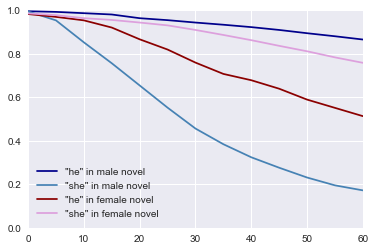

In [850]:
sns.set()
plt.plot(trim_weight, male_he_trim, 'darkblue', label='"he" in male novel')
plt.plot(trim_weight, male_she_trim, 'steelblue', label='"she" in male novel')
plt.plot(trim_weight, female_he_trim, 'darkred',  label='"he" in female novel')
plt.plot(trim_weight, female_she_trim, 'plum',  label='"she" in female novel')
plt.axis([0, 60, 0, 1])
plt.legend()

### <span style="color:green"> Exercise 3's stretch

<span style="color:green"> Ego network. "male_he" is associated with 986 words, male_she with 852, female_he with 953, and female_she with 963. Their neighbour are way too much for sub-graph. I try something random. A two-level network out of a not highly central node results in a size 385 network.   
    
<span style="color:green"> I still cannot get the plot to show Chinese. But I don't necessarily care about this graph, so I let the problem go...

In [894]:
#Redo the network as the above operations trim down the network
g_3= target_network(target_3)
#Trim the network by retaining edges that occur more than 10 times
g_3.remove_edges_from([(n1, n2) for n1, n2, d in g_3.edges(data = True) if d['weight'] <= 10])

In [901]:
#Below is a snowball that starts from the seed and expand outward 
seed= "奴隶"
layer= 2
sub_nod= set()
i= 0
while i<layer:
    if i== 0:
        neighbour= list(g_3.neighbors(seed))
        sub_nod.update(neighbour)
        to_do= neighbour
        i+= 1
    else:
        before= sub_nod
        for w in to_do:
            neighbour= list(g_3.neighbors(w))
            sub_nod.update(neighbour)
        to_do= sub_nod- before
        i+= 1
            
sub_node= sub_nod 

g_sub= g_3.subgraph(sub_node)    

print(len(sub_node), sub_node)

385 {'追求', '学员', '发动', '星球', '武道', '未知', '实战', '躲避', '绿色', '帝国', '制造', '神秀', '专业', '锻炼', '功法', '将军', '京城', '老爷', '金属', '善良', '游戏', '爷爷', '皇后', '传送', '金色', '机甲', '村长', '相当于', '威力', '爪子', '庞大', '新人', '等于', '训练', '幸运', '记载', '逃跑', '凌风', '打赏', '老妖', '炼气', '路西', '强化', '调整', '丹药', '内力', '祭祀', '技术', '具有', '根本无法', '杀死', '境界', '提升', '黄金', '奢华', '纯净', '意味着', '强者', '元气', '吸收', '匕首', '混沌', '貌似', '动物', '感应', '尊贵', '收集', '统一', '长老', '魔力', '惨叫', '知晓', '出发', '成就', '纯洁', '大师', '化为', '宗门', '魔法师', '爸爸', '宿舍', '阴阳', '级别', '射击', '大臣', '精灵', '金币', '修行', '通道', '青铜', '震撼', '带领', '杀手', '笑笑', '严厉', '召唤', '弟子', '战斗', '蜘蛛', '灵气', '飞行', '技能', '武魂', '斗气', '追杀', '武技', '波动', '教官', '少爷', '陛下', '奖励', '考试', '青云', '胜利', '事儿', '宣布', '咆哮', '数据', '融入', '植物', '军队', '打造', '增强', '火焰', '创造', '贪婪', '野蛮', '子弟', '内功', '种子', '激发', '联邦', '最低', '到达', '角色', '行走', '测试', '团队', '富贵', '鉴定', '皇宫', '尸体', '对抗', '邪恶', '公司', '森林', '武者', '城市', '部落', '基因', '敏捷', '种族', '奔跑', '教育', '细胞', '交易', '尊敬', '老爸', '高贵', '比赛', '融合', '上官', '电脑', '运用', '稳定', 

In [899]:
print(nx.info(g_sub))

Name: 
Type: SubGraph
Number of nodes: 385
Number of edges: 6849
Average degree:  35.5792


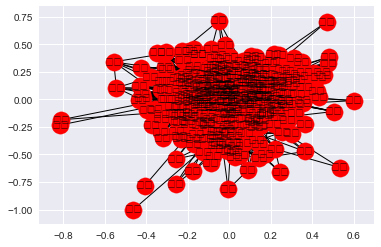

In [898]:
nx.draw_networkx(g_sub)